In [1]:
import torch
# 使用取值仅为0或1的张量表示脉冲
v=torch.rand([8])
v_th=0.5
spike=(v>=v_th).to(v)
print('spike=',spike)

spike= tensor([1., 1., 0., 1., 0., 1., 0., 1.])


In [1]:
import torch
import torch.nn as nn
from spikingjelly.activation_based import neuron,functional,layer,surrogate
from spikingjelly.activation_based import monitor
from spikingjelly import visualizing
from matplotlib import pyplot as plt

In [3]:
# 单步
lif = neuron.LIFNode()
# 多步LIF神经元
lif = neuron.MultiStepLIFNode()

In [6]:
# 新建一层IF神经元，设置为单步模式，将数据逐步输入并得到输出
net_s = neuron.LIFNode()
T = 4
N = 1
C = 3
H = 8
W = 8
x_seq = torch.rand([T, N, C, H, W])
y_seq = []
for t in range(T):
    x = x_seq[t]  # x.shape = [N, C, H, W]
    y = net_s(x)  # y.shape = [N, C, H, W]
    y_seq.append(y.unsqueeze(0))

y_seq = torch.cat(y_seq)

In [8]:
# multi_step_forward 提供了将 shape = [T, N, *] 的序列数据输入到单步模块进行逐步的前向传播的封装
net_s = neuron.LIFNode()
T = 4
N = 1
C = 3
H = 8
W = 8
x_seq = torch.rand([T, N, C, H, W])
y_seq = functional.multi_step_forward(x_seq, net_s)

In [9]:
# 也可以直接设置为多步模块，更加便捷
net_m=neuron.MultiStepLIFNode()
T = 4
N = 1
C = 3
H = 8
W = 8
x_seq = torch.rand([T, N, C, H, W])
y_seq = net_m(x_seq)
# y_seq.shape = [T, N, C, H, W]

In [10]:
# SNN中的神经元等模块，与RNN类似，带有隐藏状态
# 其输出  不仅仅与当前时刻的输入有关，还与上一个时末的状态有关
# PyTorch的设计为RNN将状态也一并输出
# 而在snn中，状态会被保存在模块内部
net_s = neuron.LIFNode()
x = torch.rand([4])
print(net_s)
print(f'the initial v={net_s.v}')
y = net_s(x)
print(f'x={x}')
print(f'y={y}')
print(f'v={net_s.v}')

LIFNode(
  v_threshold=1.0, v_reset=0.0, detach_reset=False, tau=2.0
  (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
)
the initial v=0.0
x=tensor([0.4262, 0.9639, 0.7338, 0.6399])
y=tensor([0., 0., 0., 0.])
v=tensor([0.2131, 0.4820, 0.3669, 0.3199])


In [11]:
# 在初始化后，IF神经元层的 v 会被设置为0，首次给与输入后 v 会自动广播到与输入相同的 shape
# 我们给与一个新的输入，则应该先清除神经元之前的状态，让其恢复到初始化状态
# 可以通过调用模块的 self.reset() 函数实现：
net_s = neuron.LIFNode()
x = torch.rand([4])
print(f'check point 0: v={net_s.v}')
y = net_s(x)
print(f'check point 1: v={net_s.v}')
net_s.reset()
print(f'check point 2: v={net_s.v}')
x = torch.rand([8])
y = net_s(x)
print(f'check point 3: v={net_s.v}')
# 方便起见，可以通过reset_net方法统一进行重置
# 若网络使用了有状态的模块，在训练和推理时，务必在处理完毕一个batch的数据后进行重置
# 如果忘了重置，在推理时可能输出错误的结果，而在训练时则会直接报错

check point 0: v=0.0
check point 1: v=tensor([0.3819, 0.2835, 0.4764, 0.0676])
check point 2: v=0.0
check point 3: v=tensor([0.0102, 0.0252, 0.4170, 0.2911, 0.0310, 0.4884, 0.1314, 0.2229])


In [2]:
# 若一个网络全部由单步模块构成，则整个网络的计算顺序是按照逐步传播(step-by-step)的模式进行
# 如果网络全部由多步模块构成，则整个网络的计算顺序是按照逐层传播(layer-by-layer)的模式进行
T = 4
N = 2
C = 8
x_seq = torch.rand([T, N, C]) * 64.

net = nn.Sequential(
    layer.Linear(C, 4),
    neuron.IFNode(),
    layer.Linear(4, 2),
    neuron.IFNode()
)

functional.set_step_mode(net, step_mode='m')
with torch.no_grad():
    y_seq_layer_by_layer = x_seq
    for i in range(net.__len__()):
        y_seq_layer_by_layer = net[i](y_seq_layer_by_layer)
# 其中不需要显式循环，因为 torch.nn.Sequential 已经帮我们实现过了

In [3]:
# 逐步传播和逐层传播，实际上只是计算顺序不同，它们的计算结果是完全相同的
T = 4
N = 2
C = 3
H = 8
W = 8
x_seq = torch.rand([T, N, C, H, W]) * 64.

net = nn.Sequential(
layer.Conv2d(3, 8, kernel_size=3, padding=1, stride=1, bias=False),
neuron.IFNode(),
layer.MaxPool2d(2, 2),
neuron.IFNode(),
layer.Flatten(start_dim=1),
layer.Linear(8 * H // 2 * W // 2, 10),
neuron.IFNode(),
)

print(f'net={net}')

with torch.no_grad():
    y_seq_step_by_step = []
    for t in range(T):
        x = x_seq[t]
        y = net(x)
        y_seq_step_by_step.append(y.unsqueeze(0))

    y_seq_step_by_step = torch.cat(y_seq_step_by_step, 0)
    # we can also use `y_seq_step_by_step = functional.multi_step_forward(x_seq, net)` to get the same results

    print(f'y_seq_step_by_step=\n{y_seq_step_by_step}')

    functional.reset_net(net)
    functional.set_step_mode(net, step_mode='m')
    y_seq_layer_by_layer = net(x_seq)

    max_error = (y_seq_layer_by_layer - y_seq_step_by_step).abs().max()
    print(f'max_error={max_error}')

net=Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, step_mode=s)
  (1): IFNode(
    v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=s, backend=torch
    (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
  )
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, step_mode=s)
  (3): IFNode(
    v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=s, backend=torch
    (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
  )
  (4): Flatten(start_dim=1, end_dim=-1, step_mode=s)
  (5): Linear(in_features=128, out_features=10, bias=True)
  (6): IFNode(
    v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=s, backend=torch
    (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
  )
)
y_seq_step_by_step=
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0

In [ ]:
1.SNN的计算图有2个维度，分别是时间步数和网络深度，网络的传播实际上就是生成完整计算图的过程
实际上，逐步传播是深度优先遍历，而逐层传播是广度优先遍历
尽管两者区别仅在于计算顺序，但计算速度和内存消耗上会略有区别。
2.在使用梯度替代法训练时，通常推荐使用逐层传播。在正确构建网络的情况下，逐层传播的并行度更大，速度更快

In [5]:
# multi_step_forward 可以将一个单步模块进行多步传播，
# 而 MultiStepContainer 则可以将一个单步模块包装成多步模块
net_s = neuron.IFNode(step_mode='s')
T = 4
N = 1
C = 3
H = 8
W = 8
x_seq = torch.rand([T, N, C, H, W])
y_seq = functional.multi_step_forward(x_seq, net_s)
# y_seq.shape = [T, N, C, H, W]

net_s.reset()
net_m = layer.MultiStepContainer(net_s)
z_seq = net_m(x_seq)

  v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=s, backend=torch
  (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
) supports for step_mode == 's', which should not be contained by MultiStepContainer!


In [6]:
# 对于无状态的ANN网络层，例如 torch.nn.Conv2d，
# 其本身要求输入数据的 shape = [N, *]，若用于多步模式，则可以用多步的包装器进行包装
# 但是ANN的网络层本身是无状态的，不存在前序依赖，没有必要在时间上串行的计算
# 可以使用函数风格的 seq_to_ann_forward 或模块风格的 SeqToANNContainer 进行包装
# seq_to_ann_forward 将 shape = [T, N, *] 的数据首先变换为 shape = [TN, *]，
# 再送入无状态的网络层进行计算，最后结果返回原来的模样
# 同时刻的数据是并行计算的，因而速度更快：
with torch.no_grad():
    T = 4
    N = 1
    C = 3
    H = 8
    W = 8
    x_seq = torch.rand([T, N, C, H, W])

    conv = nn.Conv2d(C, 8, kernel_size=3, padding=1, bias=False)
    bn = nn.BatchNorm2d(8)

    y_seq = functional.multi_step_forward(x_seq, (conv, bn))
    # y_seq.shape = [T, N, 8, H, W]

    net = layer.MultiStepContainer(conv, bn)
    z_seq = net(x_seq)
    # z_seq.shape = [T, N, 8, H, W]

    # z_seq is identical to y_seq

    p_seq = functional.seq_to_ann_forward(x_seq, (conv, bn))
    # p_seq.shape = [T, N, 8, H, W]

    net = layer.SeqToANNContainer(conv, bn)
    q_seq = net(x_seq)
    # q_seq.shape = [T, N, 8, H, W]

In [7]:
# 常用的网络层，在 spikingjelly.activation_based.layer 已经定义过
# 因此更推荐使用 spikingjelly.activation_based.layer 中的网络层
# 尽管spikingjelly.activation_based.layer中的网络层也就是用包装器包装forward函数实现的
# spikingjelly.activation_based.layer 中的网络层，优势在于：
# ①支持单步和多步模式，而 SeqToANNContainer 和 MultiStepContainer 包装的层，只支持多步模式
# ②包装器会使得 state_dict 的 keys() 也增加一层包装，给加载权重带来麻烦
ann = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, padding=1, bias=False),
    nn.BatchNorm2d(8),
    nn.ReLU()
)

print(f'ann.state_dict.keys()={ann.state_dict().keys()}')

net_container = nn.Sequential(
    layer.SeqToANNContainer(
        nn.Conv2d(3, 8, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(8),
    ),
    neuron.IFNode(step_mode='m')
)
print(f'net_container.state_dict.keys()={net_container.state_dict().keys()}')

net_origin = nn.Sequential(
    layer.Conv2d(3, 8, kernel_size=3, padding=1, bias=False),
    nn.BatchNorm2d(8),
    neuron.IFNode(step_mode='m')
)
print(f'net_origin.state_dict.keys()={net_origin.state_dict().keys()}')

try:
    print('net_container is trying to load state dict from ann...')
    net_container.load_state_dict(ann.state_dict())
    print('Load success!')
except BaseException as e:
    print('net_container can not load! The error message is\n', e)

try:
    print('net_origin is trying to load state dict from ann...')
    net_origin.load_state_dict(ann.state_dict())
    print('Load success!')
except BaseException as e:
    print('net_origin can not load! The error message is', e)

ann.state_dict.keys()=odict_keys(['0.weight', '1.weight', '1.bias', '1.running_mean', '1.running_var', '1.num_batches_tracked'])
net_container.state_dict.keys()=odict_keys(['0.0.weight', '0.1.weight', '0.1.bias', '0.1.running_mean', '0.1.running_var', '0.1.num_batches_tracked'])
net_origin.state_dict.keys()=odict_keys(['0.weight', '1.weight', '1.bias', '1.running_mean', '1.running_var', '1.num_batches_tracked'])
net_container is trying to load state dict from ann...
net_container can not load! The error message is
 Error(s) in loading state_dict for Sequential:
	Missing key(s) in state_dict: "0.0.weight", "0.1.weight", "0.1.bias", "0.1.running_mean", "0.1.running_var". 
	Unexpected key(s) in state_dict: "0.weight", "1.weight", "1.bias", "1.running_mean", "1.running_var", "1.num_batches_tracked". 
net_origin is trying to load state dict from ann...
Load success!


In [ ]:
# MultiStepContainer 和 SeqToANNContainer 都是只支持多步模式的，不允许切换为单步模式。

# StepModeContainer 类似于融合版的 MultiStepContainer 和 SeqToANNContainer，可以用于包装无状态或有状态的单步模块，需要在包装时指明是否有状态，但此包装器还支持切换单步和多步模式。

In [8]:
# 使用 set_step_mode 改变 StepModeContainer 是安全的，只会改变包装器本身的 step_mode，而包装器内的模块仍然保持单步
# 如果模块本身就支持单步和多步模式的切换，则不推荐使用 MultiStepContainer 或 StepModeContainer 对其进行包装。因为包装器使用的多步前向传播，可能不如模块自身定义的前向传播速度快。
# 通常需要用到 MultiStepContainer 或 StepModeContainer 的是一些没有定义多步的模块，例如一个在 torch.nn 中存在，但在 spikingjelly.activation_based.layer 中不存在的网络层。
with torch.no_grad():
    net = layer.StepModeContainer(
        True,
        neuron.IFNode()
    )
    functional.set_step_mode(net, 'm')
    print(f'net.step_mode={net.step_mode}')
    print(f'net[0].step_mode={net[0].step_mode}')

  v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=s, backend=torch
  (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
) supports for step_mode == 's', which should not be contained by StepModeContainer!


net.step_mode=m
net[0].step_mode=s


In [15]:
# 介绍 spikingjelly.activation_based.neuron，介绍脉冲神经元。
# 在 spikingjelly 中，我们约定，只能输出脉冲，即0或1的神经元，都可以称之为“脉冲神经元”
# 使用脉冲神经元的网络，进而也可以称之为脉冲神经元网络(Spiking Neural Networks, SNNs)

In [10]:
# 新建一个IF神经元层
if_layer = neuron.IFNode()
# IF神经元层有一些构造参数
# v_threshold – 神经元的阈值电压
# v_reset – 神经元的重置电压。如果不为 None，当神经元释放脉冲后，电压会被重置为 v_reset；如果设置为 None，则电压会被减去 v_threshold
# surrogate_function – 反向传播时用来计算脉冲函数梯度的替代函数
# 神经元的数量：
# spikingjelly.activation_based.neuron.IFNode 中的绝大多数神经元层，神经元的数量是在初始化或调用 reset() 函数重新初始化后，根据第一次接收的输入的 shape 自动决定的。

# 与RNN中的神经元非常类似，脉冲神经元也是有状态的，或者说是有记忆
# 脉冲神经元的状态变量，一般是它的膜电位v[t]
# 因此，spikingjelly.activation_based.neuron 中的神经元，都有成员变量 v
print(if_layer.v)

0.0


In [11]:
# 没有任何输入时，其电压值为0
x=torch.rand(size=[2,3])
if_layer(x)
print(f'x.shape={x.shape},if_layer.v.shape={if_layer.v.shape}')
if_layer.reset()

x = torch.rand(size=[4, 5, 6])
if_layer(x)
print(f'x.shape={x.shape}, if_layer.v.shape={if_layer.v.shape}')
# x.shape=torch.Size([4, 5, 6]), if_layer.v.shape=torch.Size([4, 5, 6])
if_layer.reset()

x.shape=torch.Size([2, 3]),if_layer.v.shape=torch.Size([2, 3])
x.shape=torch.Size([4, 5, 6]), if_layer.v.shape=torch.Size([4, 5, 6])


In [ ]:
脉冲神经元是有状态的，在输入下一个样本前，一定要先调用 reset() 函数清除之前的状态。
在脉冲神经元中， 不仅取决于当前时刻的输入 ，还取决于它在上一个时刻末的膜电位 。
neuron中的神经元，使用离散的差分方程来近似连续的微分方程


不同的神经元，充电方程不尽相同。
但膜电位超过阈值电压后，释放脉冲，以及释放脉冲后，膜电位的重置都是相同的。
因此它们全部继承自 spikingjelly.activation_based.neuron.BaseNode，共享相同的放电、重置方程。

In [ ]:
surrogate_function() 在前向传播时是阶跃函数，只要输入大于或等于0，就会返回1，否则会返回0。
我们将这种元素仅为0或1的 tensor 视为脉冲。
释放脉冲消耗了神经元之前积累的电荷，因此膜电位会有一个瞬间的降低，即膜电位的重置。
在SNN中，对膜电位重置的实现，有2种方式：
1.Hard方式：释放脉冲后，膜电位直接被设置成重置电压：Vt=Vreset
2.Soft方式：释放脉冲后，膜电位减去阈值电压：Vt=Vt-Vthreshold
对于使用Soft方式的神经元，并不需要重置电压reset这个变量
neuron中的神经元，在构造函数的参数之一 v_reset，默认为 1.0 ，表示神经元使用Hard方式；若设置为 None，则会使用Soft方式

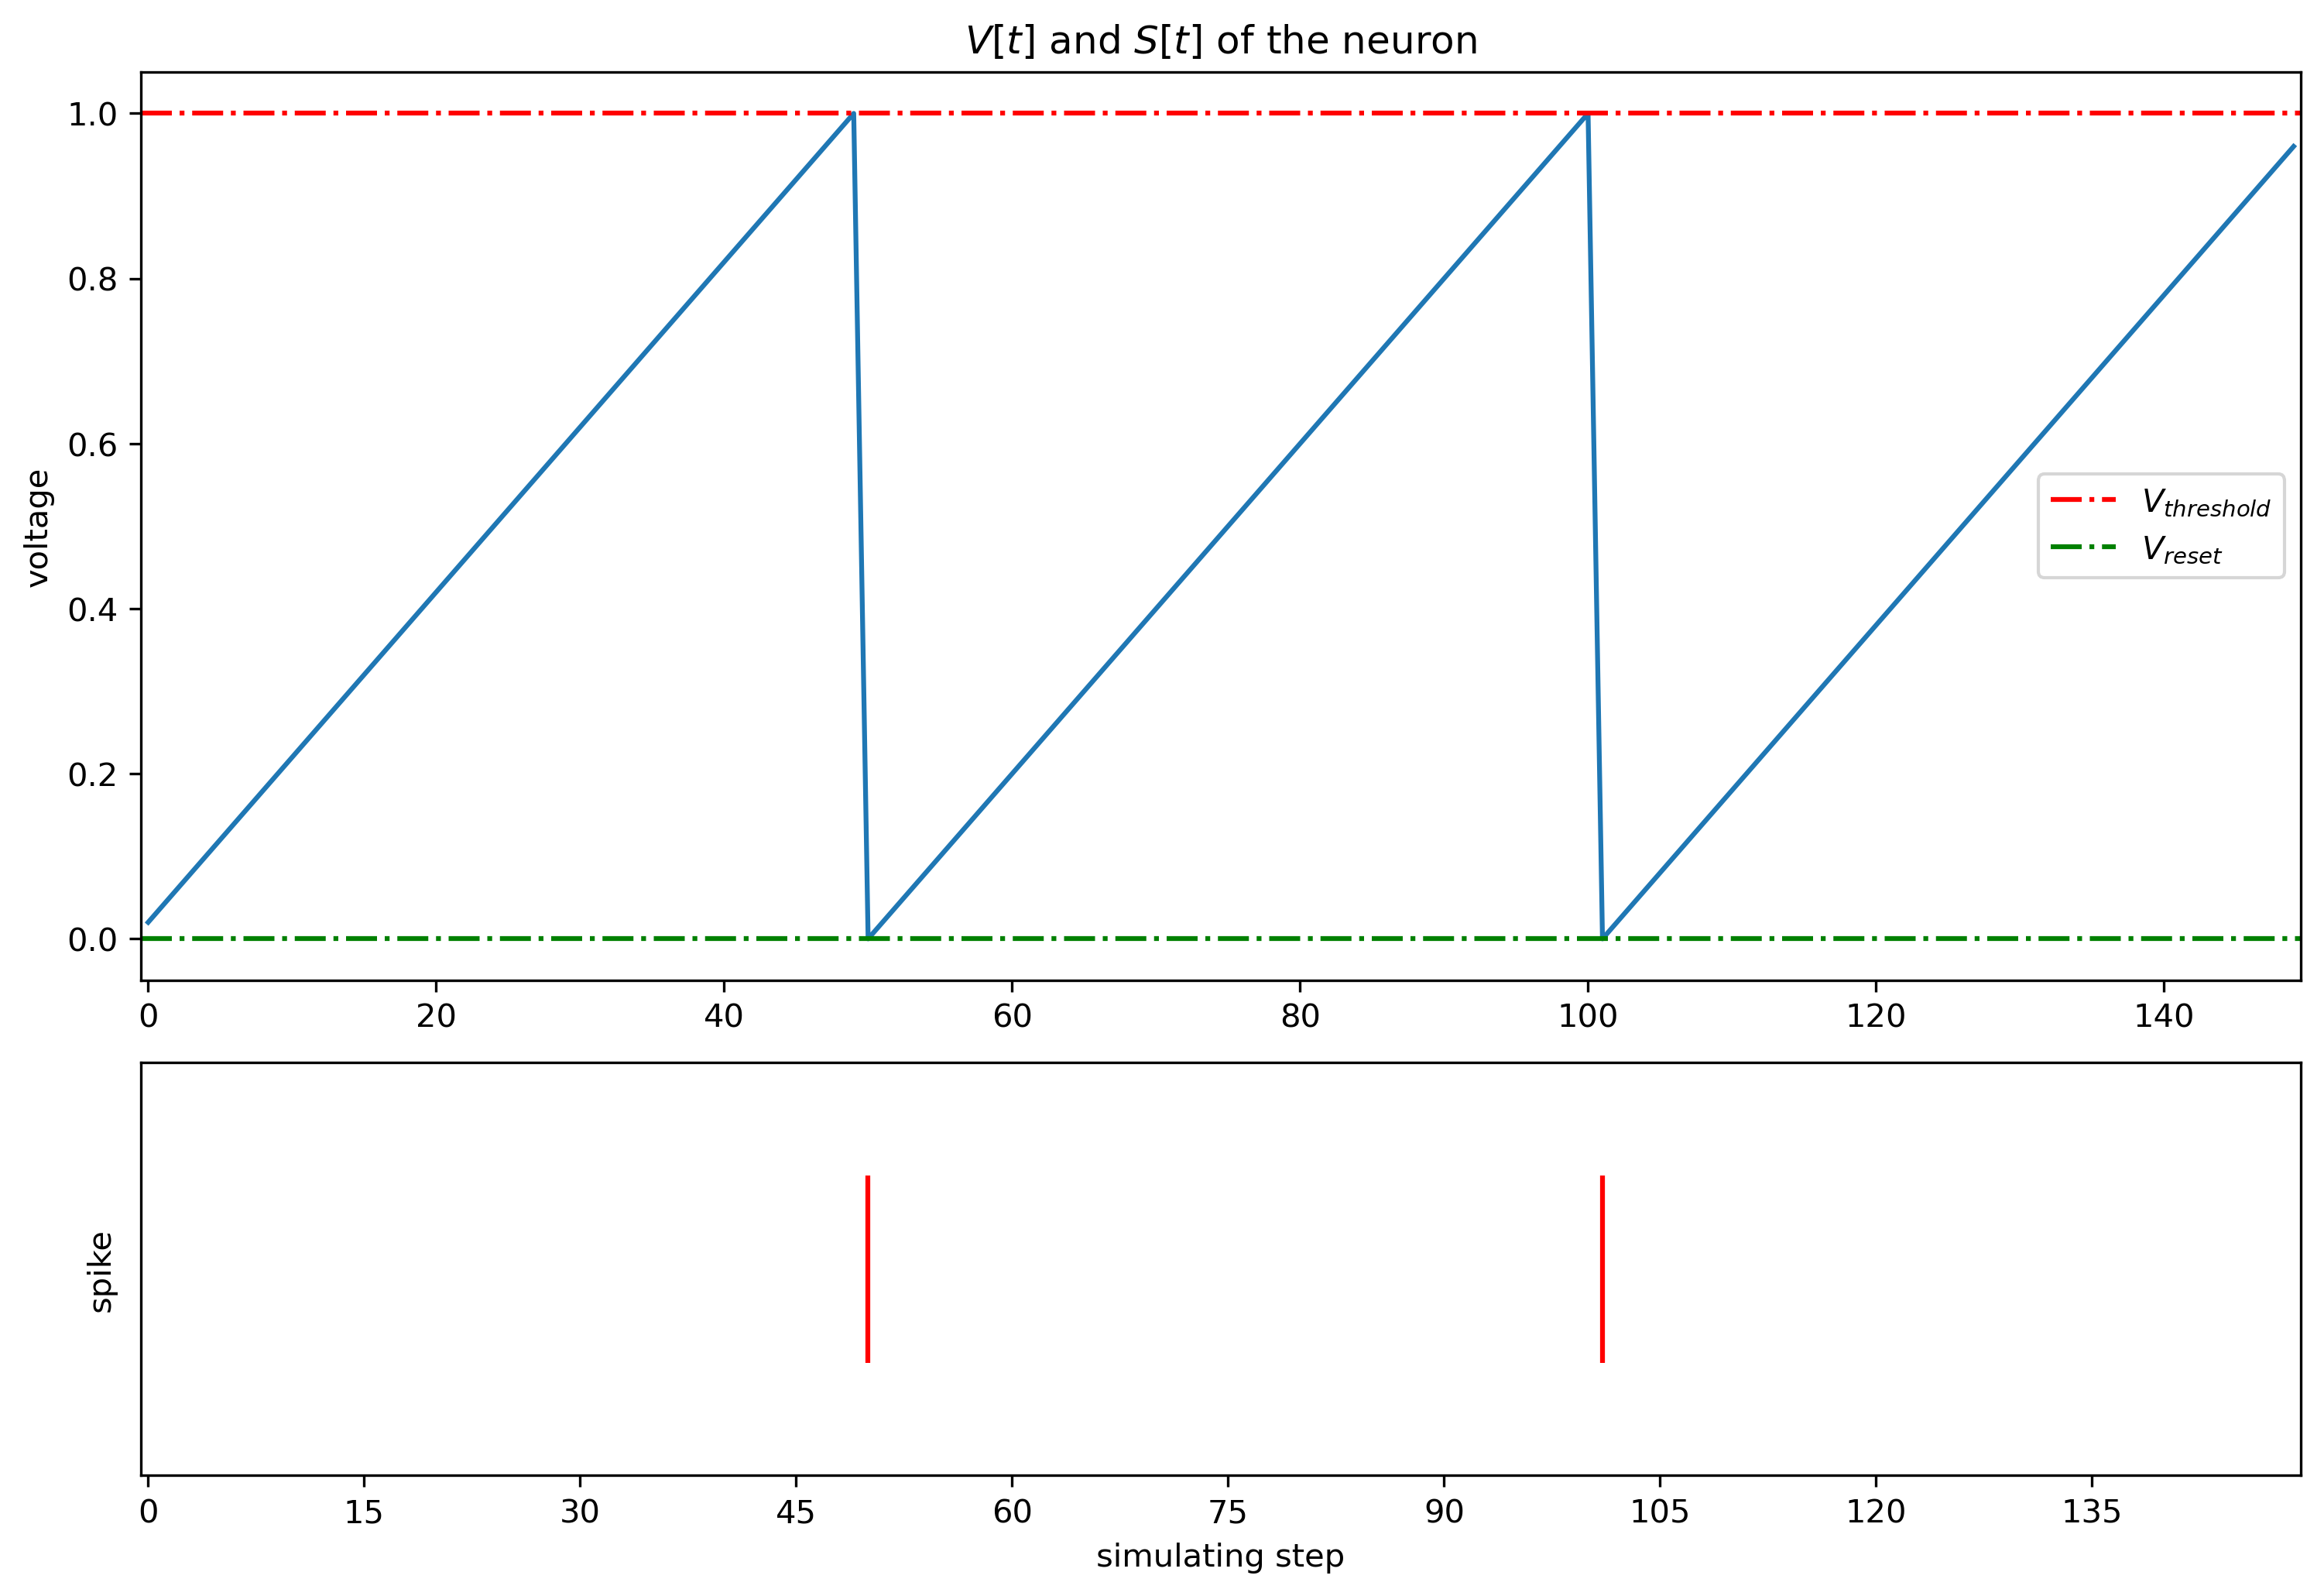

In [12]:
# 逐步给与神经元输入，并查看它的膜电位和输出脉冲
if_layer.reset()
x = torch.as_tensor([0.02])
T = 150
s_list = []
v_list = []
for t in range(T):
    s_list.append(if_layer(x))
    v_list.append(if_layer.v)

dpi = 300
figsize = (12, 8)
visualizing.plot_one_neuron_v_s(torch.cat(v_list).numpy(), torch.cat(s_list).numpy(), v_threshold=if_layer.v_threshold,
                                v_reset=if_layer.v_reset,
                                figsize=figsize, dpi=dpi)
plt.show()
# 我们给与的输入 shape=[1]，因此这个IF神经元层只有1个神经元

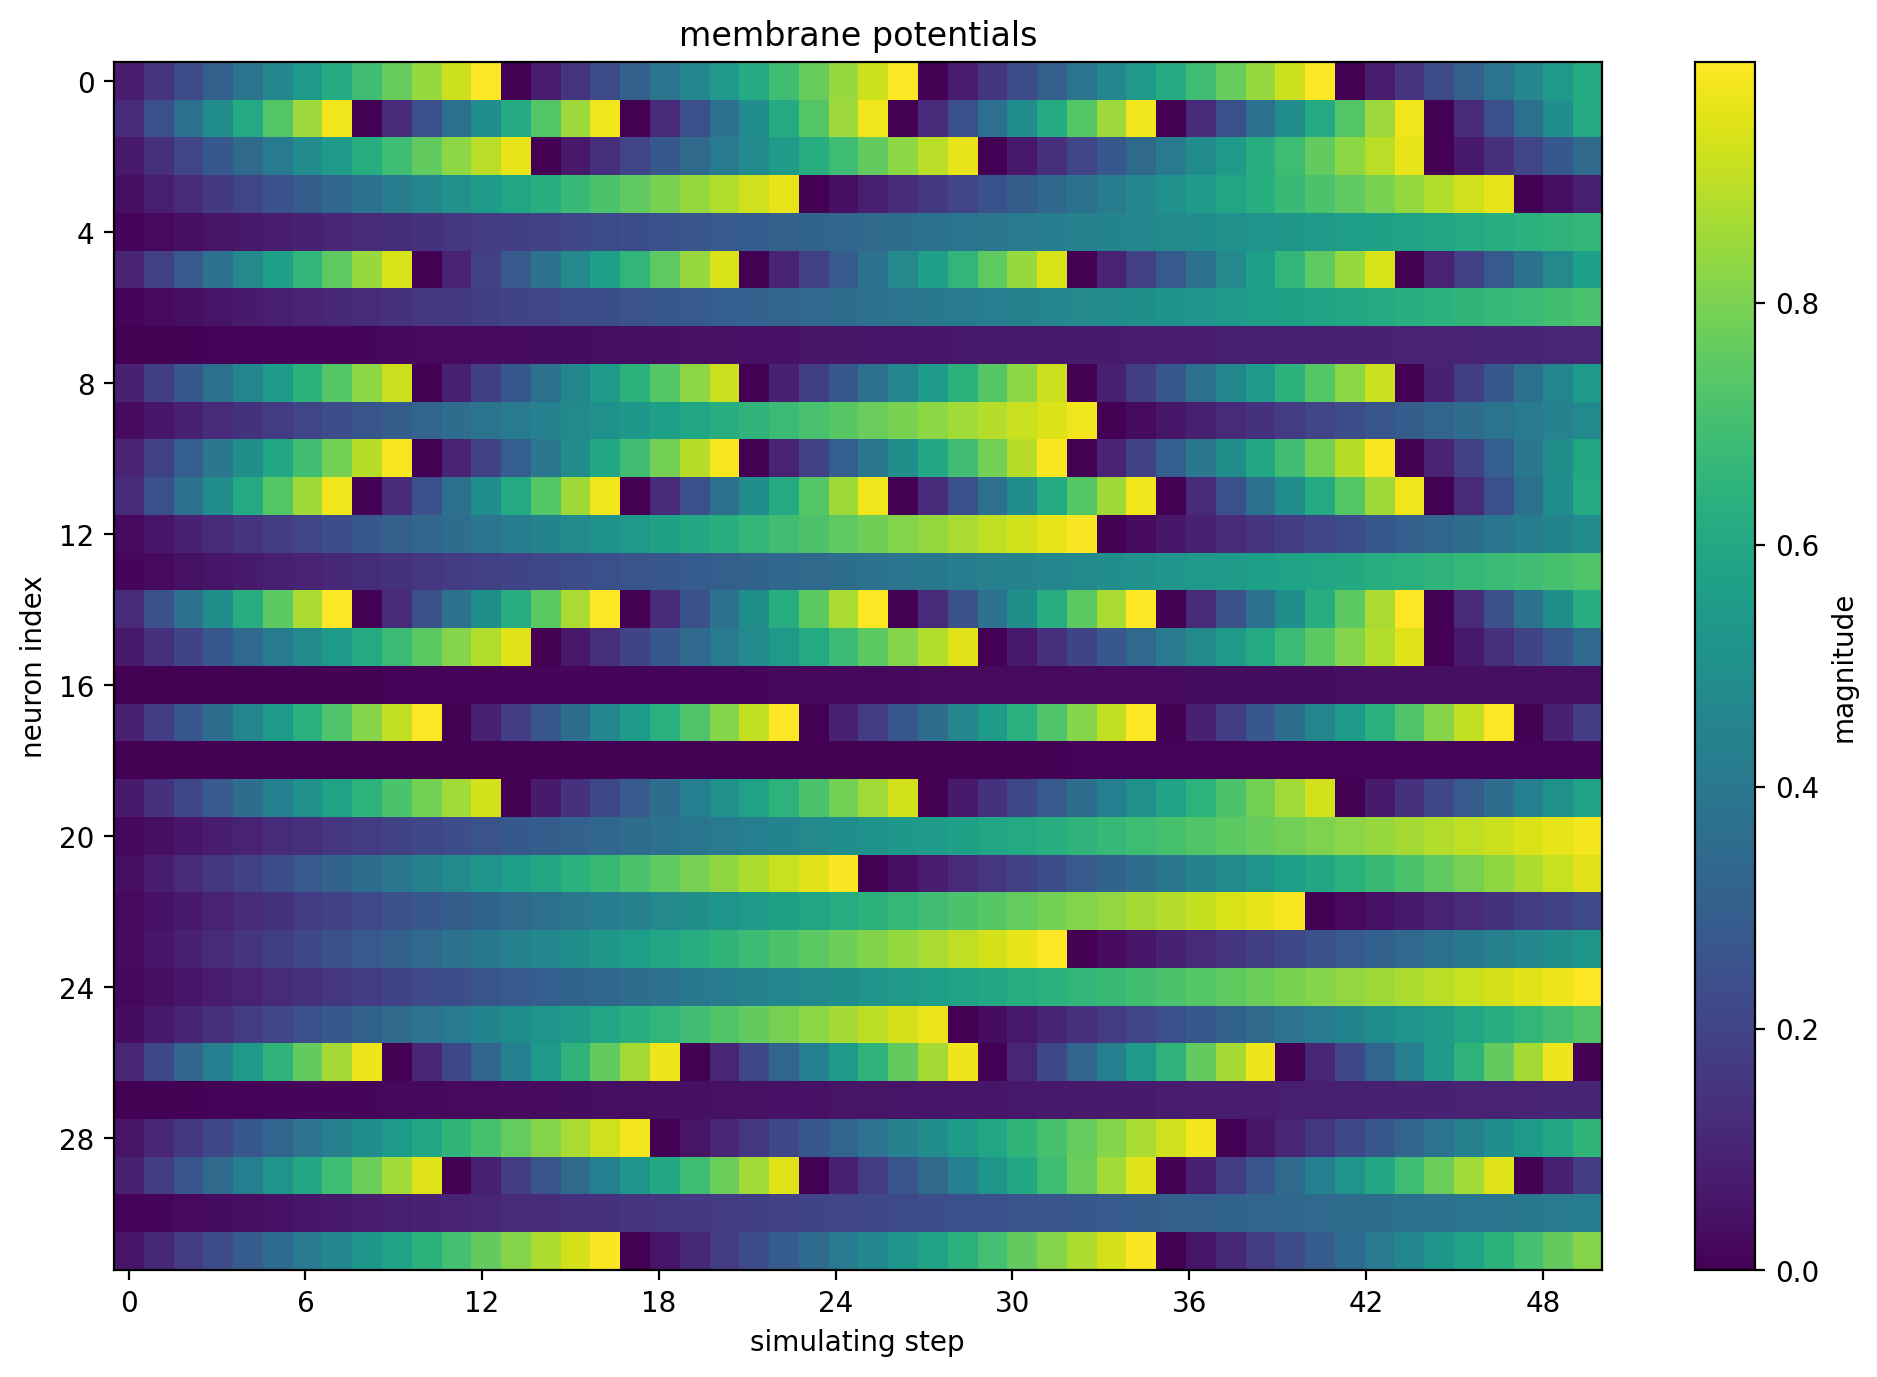

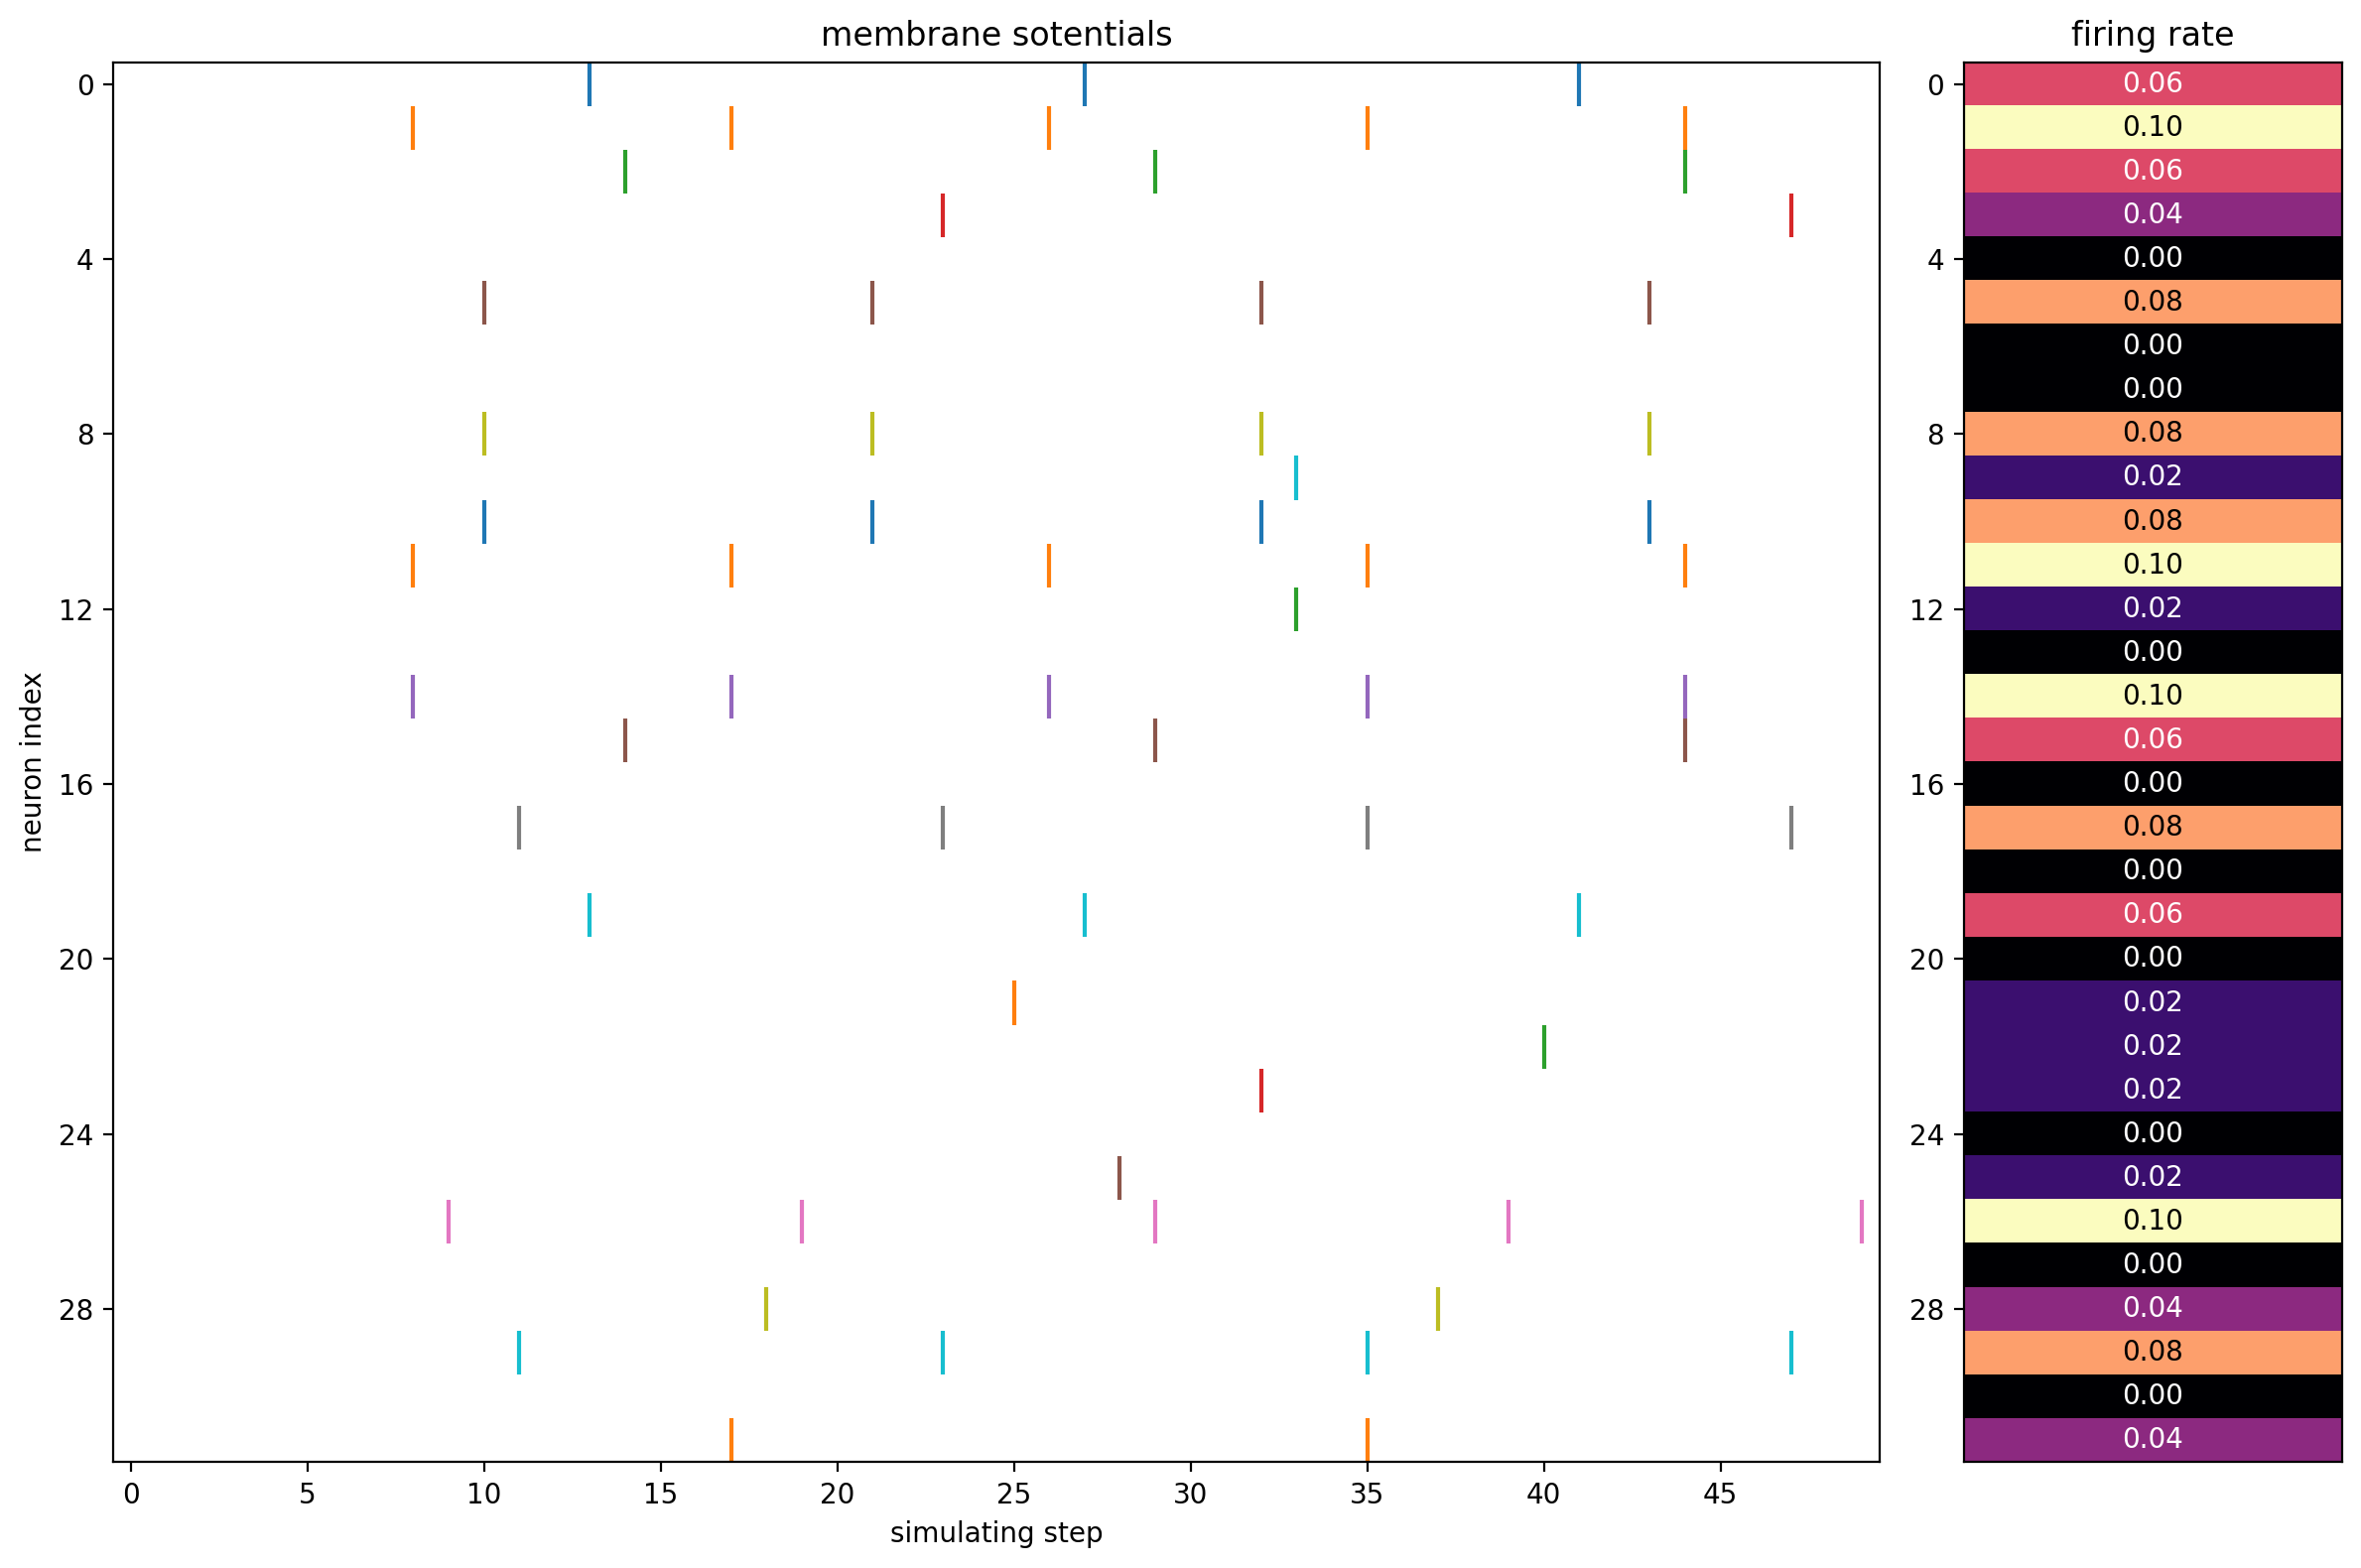

In [13]:
# 将神经元层重置，并给与 shape=[32] 的输入，查看这32个神经元的膜电位和输出脉冲
if_layer.reset()
T = 50
x = torch.rand([32]) / 8.
s_list = []
v_list = []
for t in range(T):
    s_list.append(if_layer(x).unsqueeze(0))
    v_list.append(if_layer.v.unsqueeze(0))

s_list = torch.cat(s_list)
v_list = torch.cat(v_list)

figsize = (12, 8)
dpi = 200
visualizing.plot_2d_heatmap(array=v_list.numpy(), title='membrane potentials', xlabel='simulating step',
                            ylabel='neuron index', int_x_ticks=True, x_max=T, figsize=figsize, dpi=dpi)


visualizing.plot_1d_spikes(spikes=s_list.numpy(), title='membrane sotentials', xlabel='simulating step',
                        ylabel='neuron index', figsize=figsize, dpi=dpi)

plt.show()

In [17]:
# 切换成多步模式非常简单，只需要设置 step_mode 即可
# 此外，部分神经元在多步模式下支持 cupy 后端。在 cupy模式下，前反向传播会使用CuPy进行加速
# SpikingJelly使用充电、放电、重置三个方程来描述脉冲神经元
# 单步模式下的前向传播 single_step_forward 函数即是由这3个过程组成：
def single_step_forward(self, x: torch.Tensor):
    # 充电
    self.neuronal_charge(x)
    # 放电
    spike = self.neuronal_fire()
    # 重置
    self.neuronal_reset(spike)
    return spike

In [18]:
# 大多数神经元的放电和重置都相同
# 不同的神经元主要是构造函数和充电方程不同
# 因此，若想实现新的神经元，则只需要更改构造函数和充电方程即可。
# 构造新的神经元
class SquareIFNode(neuron.BaseNode):
    def neuronal_charge(self, x: torch.Tensor):
        self.v = self.v + x ** 2

In [19]:
# 因为BaseNode 继承自 MemoryModule，而MemoryModule 默认的多步传播
# 因此我们定义 neuronal_charge 后，multi_step_forward 也可以被使用
# 使用平方积分发放神经元进行单步或多步传播
class SquareIFNode(neuron.BaseNode):

    def neuronal_charge(self, x: torch.Tensor):
        self.v = self.v + x ** 2

sif_layer = SquareIFNode()

T = 4
N = 1
x_seq = torch.rand([T, N])
print(f'x_seq={x_seq}')

for t in range(T):
    yt = sif_layer(x_seq[t])
    print(f'sif_layer.v[{t}]={sif_layer.v}')

sif_layer.reset()
sif_layer.step_mode = 'm'
y_seq = sif_layer(x_seq)
print(f'y_seq={y_seq}')
sif_layer.reset()

x_seq=tensor([[0.5322],
        [0.4506],
        [0.9821],
        [0.2674]])
sif_layer.v[0]=tensor([0.2833])
sif_layer.v[1]=tensor([0.4863])
sif_layer.v[2]=tensor([0.])
sif_layer.v[3]=tensor([0.0715])
y_seq=tensor([[0.],
        [0.],
        [1.],
        [0.]])


In [21]:
# 直接使用冲激函数进行梯度下降，显然会使得网络的训练及其不稳定
# 替代函数在神经元中被用于生成脉冲
# 替代通常是一个形状与原函数类似，但光滑连续的函数。
# 在 spikingjelly.activation_based.surrogate 中提供了一些常用的替代函数
# 其中Sigmoid函数为spikingjelly.activation_based.surrogate.Sigmoid
# 使用替代函数就像是使用函数一样：
sg = surrogate.Sigmoid(alpha=4.)

x = torch.rand([8]) - 0.5
x.requires_grad = True
y = sg(x)
y.sum().backward()
print(f'x={x}')
print(f'y={y}')
print(f'x.grad={x.grad}')

x=tensor([ 0.2755, -0.3933,  0.3879,  0.4229,  0.0415, -0.0936, -0.0483,  0.0973],
       requires_grad=True)
y=tensor([1., 0., 1., 1., 1., 0., 0., 1.], grad_fn=<sigmoidBackward>)
x.grad=tensor([0.7488, 0.5690, 0.5772, 0.5254, 0.9931, 0.9658, 0.9907, 0.9631])


In [22]:
# 每个替代函数，除了有形如 spikingjelly.activation_based.surrogate.Sigmoid 的模块风格API
# 也提供了形如 spikingjelly.activation_based.surrogate.sigmoid 函数风格的API
# 模块风格的API使用驼峰命名法，而函数风格的API使用下划线命名法
# 关系类似于 torch.nn 和 torch.nn.functional
alpha = 4.
x = torch.rand([8]) - 0.5
x.requires_grad = True
y = surrogate.sigmoid.apply(x, alpha)
y.sum().backward()
print(f'x={x}')
print(f'y={y}')
print(f'x.grad={x.grad}')
# 替代函数通常会有1个或多个控制形状的超参数

x=tensor([-0.3059,  0.2496, -0.1359,  0.1072, -0.4909,  0.4726,  0.3912,  0.0674],
       requires_grad=True)
y=tensor([0., 1., 0., 1., 0., 1., 1., 1.], grad_fn=<sigmoidBackward>)
x.grad=tensor([0.7026, 0.7870, 0.9296, 0.9554, 0.4317, 0.4559, 0.5721, 0.9820])


In [6]:
# 在 spikingjelly.activation_based.monitor 中定义了几个通用的监视器类
# 用户可以使用这些监视器实现复杂的数据记录功能
# 搭建一个简单的多步网络，了避免无脉冲释放，我们将权重全部设置为正值
net = nn.Sequential(
    layer.Linear(8, 4),
    neuron.IFNode(),
    layer.Linear(4, 2),
    neuron.IFNode()
)

for param in net.parameters():
    param.data.abs_()

functional.set_step_mode(net, 'm')

In [7]:
# spikingjelly.activation_based.monitor.OutputMonitor
# 可以记录网络中任何类型为 instance 的模块的输出
# 脉冲神经元层的输出即为脉冲，
# 因此我们可以使用 OutputMonitor 来构建一个脉冲监视器，记录网络中所有 neuron.IFNode 的输出脉冲
spike_seq_monitor = monitor.OutputMonitor(net, neuron.IFNode)
T = 4
N = 1
x_seq = torch.rand([T, N, 8])

with torch.no_grad():
    net(x_seq)
# 要记录的数据，会根据生成顺序，保存在 .records 的 list 中：
print(f'spike_seq_monitor.records=\n{spike_seq_monitor.records}')
# 使用索引，直接访问被记录的第 i 个数据
print(f'spike_seq_monitor[1]={spike_seq_monitor[1]}')

spike_seq_monitor.records=
[tensor([[[0., 1., 1., 0.]],

        [[1., 0., 0., 1.]],

        [[0., 1., 1., 0.]],

        [[1., 1., 0., 1.]]]), tensor([[[0., 0.]],

        [[0., 1.]],

        [[1., 0.]],

        [[0., 1.]]])]
spike_seq_monitor[1]=tensor([[[0., 0.]],

        [[0., 1.]],

        [[1., 0.]],

        [[0., 1.]]])


In [8]:
# .monitored_layers 记录了被监视器监控的层的名字
print(f'net={net}')
print(f'spike_seq_monitor.monitored_layers={spike_seq_monitor.monitored_layers}')
# 可以直接通过层的名字作为索引，访问某一层被记录的数据。这返回的是一个 list
print(f"spike_seq_monitor['1']={spike_seq_monitor['1']}")

net=Sequential(
  (0): Linear(in_features=8, out_features=4, bias=True)
  (1): IFNode(
    v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=m, backend=torch
    (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
  )
  (2): Linear(in_features=4, out_features=2, bias=True)
  (3): IFNode(
    v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=m, backend=torch
    (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
  )
)
spike_seq_monitor.monitored_layers=['1', '3']
spike_seq_monitor['1']=[tensor([[[0., 1., 1., 0.]],

        [[1., 0., 0., 1.]],

        [[0., 1., 1., 0.]],

        [[1., 1., 0., 1.]]])]


In [9]:
# 可以通过调用 .clear_recorded_data() 来清空已经记录的数据
spike_seq_monitor.clear_recorded_data()
print(f'spike_seq_monitor.records={spike_seq_monitor.records}')
print(f"spike_seq_monitor['1']={spike_seq_monitor['1']}")

spike_seq_monitor.records=[]
spike_seq_monitor['1']=[]


In [10]:
# 所有的 monitor 在析构时都会自动删除已经注册的钩子
# 但python的内存回收机制并不保证在手动调用 del 时一定会进行析构
# 此删除一个监视器，并不能保证钩子也立刻被删除
del spike_seq_monitor # 钩子可能仍然在起作用
# 立刻删除钩子，应该通过以下方式：
spike_seq_monitor.remove_hooks()

NameError: name 'spike_seq_monitor' is not defined

In [11]:
# OutputMonitor 还支持在记录数据时就对数据进行简单的处理,只需要指定function_on_output
# function_on_output 的默认值是 lambda x: x，也就是默认不进行任何处理
def cal_firing_rate(s_seq: torch.Tensor):
    # s_seq.shape = [T, N, *]
    return s_seq.flatten(1).mean(1)
# 构建发放率监视器
fr_monitor = monitor.OutputMonitor(net, neuron.IFNode, cal_firing_rate)

In [12]:
# 通过 .disable() 可以让 monitor 暂停记录
# 而 .enable() 则可以让其重新开始记录
with torch.no_grad():
    functional.reset_net(net)
    fr_monitor.disable()
    net(x_seq)
    functional.reset_net(net)
    print(f'after call fr_monitor.disable(), fr_monitor.records=\n{fr_monitor.records}')

    fr_monitor.enable()
    net(x_seq)
    print(f'after call fr_monitor.enable(), fr_monitor.records=\n{fr_monitor.records}')
    functional.reset_net(net)
    del fr_monitor

after call fr_monitor.disable(), fr_monitor.records=
[]
after call fr_monitor.enable(), fr_monitor.records=
[tensor([0.5000, 0.5000, 0.5000, 0.7500]), tensor([0.0000, 0.5000, 0.5000, 0.5000])]


In [13]:
# 记录模块成员变量
# 如神经元的电压，可以通过 spikingjelly.activation_based.monitor.AttributeMonitor 实现
# 神经元构造参数中的 store_v_seq: bool = False 表示在默认情况下，只记录当前时刻的电压
# 想记录所有时刻的电压，则将其更改为 True
for m in net.modules():
    if isinstance(m, neuron.IFNode):
        m.store_v_seq = True

In [14]:
# 新建记录电压序列的监视器并进行记录
v_seq_monitor = monitor.AttributeMonitor('v_seq', pre_forward=False, net=net, instance=neuron.IFNode)
with torch.no_grad():
    net(x_seq)
    print(f'v_seq_monitor.records=\n{v_seq_monitor.records}')
    functional.reset_net(net)
    del v_seq_monitor

v_seq_monitor.records=
[tensor([[[0.9687, 0.0000, 0.0000, 0.9879]],

        [[0.0000, 0.8743, 0.9117, 0.0000]],

        [[0.9649, 0.0000, 0.0000, 0.9964]],

        [[0.0000, 0.0000, 0.9223, 0.0000]]]), tensor([[[0.5890, 0.3240]],

        [[0.8170, 0.0000]],

        [[0.0000, 0.3240]],

        [[0.6278, 0.0000]]])]


In [15]:
# 记录模块输入
# 与记录模块成员变量的方法一致
input_monitor = monitor.InputMonitor(net, neuron.IFNode)
with torch.no_grad():
    net(x_seq)
    print(f'input_monitor.records=\n{input_monitor.records}')
    functional.reset_net(net)
    del input_monitor

input_monitor.records=
[tensor([[[0.9687, 1.1096, 1.0528, 0.9879]],

        [[0.9492, 0.8743, 0.9117, 0.8788]],

        [[0.9649, 1.0562, 1.0066, 0.9964]],

        [[0.8221, 1.0011, 0.9223, 0.9850]]]), tensor([[[0.5890, 0.3240]],

        [[0.2280, 0.9672]],

        [[0.5890, 0.3240]],

        [[0.6278, 1.1787]]])]


In [16]:
# 记录模块的输入梯度
# 记录每一层脉冲神经元的输入梯度
# 可以使用 spikingjelly.activation_based.monitor.GradOutputMonitor 轻松实现
spike_seq_grad_monitor = monitor.GradOutputMonitor(net, neuron.IFNode)
net(x_seq).sum().backward()
print(f'spike_seq_grad_monitor.records=\n{spike_seq_grad_monitor.records}')
functional.reset_net(net)
del spike_seq_grad_monitor

spike_seq_grad_monitor.records=
[tensor([[[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]]]), tensor([[[0.2015, 0.5401, 0.0736, 0.2320]],

        [[0.1016, 0.3909, 0.0570, 0.1139]],

        [[0.2453, 0.1653, 0.0070, 0.2949]],

        [[0.1921, 0.3283, 0.0388, 0.2259]]])]


In [17]:
# 记录模块的输出梯度
# 使用 spikingjelly.activation_based.monitor.GradInputMonitor 可以轻松记录模块的输出梯度
# 调节不同的alpha值来进行计算
net = []
for i in range(10):
    net.append(layer.Linear(8, 8))
    net.append(neuron.IFNode())

net = nn.Sequential(*net)

functional.set_step_mode(net, 'm')

T = 4
N = 1
x_seq = torch.rand([T, N, 8])

input_grad_monitor = monitor.GradInputMonitor(net, neuron.IFNode, function_on_grad_input=torch.norm)

for alpha in [0.1, 0.5, 2, 4, 8]:
    for m in net.modules():
        if isinstance(m, surrogate.Sigmoid):
            m.alpha = alpha
    net(x_seq).sum().backward()
    print(f'alpha={alpha}, input_grad_monitor.records=\n{input_grad_monitor.records}\n')
    functional.reset_net(net)
    # zero grad
    for param in net.parameters():
        param.grad.zero_()

    input_grad_monitor.records.clear()

alpha=0.1, input_grad_monitor.records=
[tensor(0.3866), tensor(0.0096), tensor(0.0003), tensor(5.2466e-06), tensor(7.3671e-08), tensor(1.0580e-09), tensor(2.3056e-11), tensor(4.8369e-13), tensor(6.8129e-15), tensor(1.0633e-16)]

alpha=0.5, input_grad_monitor.records=
[tensor(1.7885), tensor(0.2070), tensor(0.0273), tensor(0.0022), tensor(0.0001), tensor(7.0861e-06), tensor(6.9055e-07), tensor(6.5414e-08), tensor(4.4589e-09), tensor(3.0938e-10)]

alpha=2, input_grad_monitor.records=
[tensor(3.5012), tensor(0.8017), tensor(0.1828), tensor(0.0277), tensor(0.0043), tensor(0.0014), tensor(0.0004), tensor(4.3584e-05), tensor(5.8583e-06), tensor(6.4173e-07)]

alpha=4, input_grad_monitor.records=
[tensor(2.9305), tensor(0.5525), tensor(0.1319), tensor(0.0271), tensor(0.0030), tensor(0.0012), tensor(0.0004), tensor(9.6786e-05), tensor(3.0050e-05), tensor(4.4153e-06)]

alpha=8, input_grad_monitor.records=
[tensor(1.2679), tensor(0.3013), tensor(0.0725), tensor(0.0254), tensor(0.0009), tensor(0.0